In [22]:
import matplotlib.pyplot as plt
import mpltern

In [2]:
import bfn.train_and_sample as tas
import bfn.example_data as example_data
import bfn.training as training
import bfn.models as models

In [3]:
import jax.numpy as jnp
import jax.random as jr
import flax.linen as nn
import jax
import optax
from tqdm import tqdm
from functools import partial
from jaxtyping import Int, Float, Array, Key

### Plotting $p_F(\cdot | \mathbf{x}; t)$

In [122]:
@partial(jax.jit, static_argnums=(1, 4), static_argnames=("bins",))
def flow(x: Int[Array, "D"], k: int, t: Float, beta: float, samples: int, *, key: Key, bins: int = 100):
    """Calculate the flow distribution for a certain observation."""
    beta_t = beta * (t**2)
    oh_x = jax.nn.one_hot(x, k, axis=-2)
    normals = jr.normal(key, shape=(samples, *oh_x.shape))
    y = beta_t * (k * oh_x - 1) + jnp.sqrt(beta_t * k) * normals
    thetas_y = jax.nn.softmax(y, axis=-2)

    thetas_y = thetas_y[:, :, 0]  # TODO Make this a reshape
    density = jnp.histogramdd(thetas_y, bins=bins, range=[(0.0, 1.0)]*k, density=True)
    return density

#### Generating Stochastic $\boldsymbol{\theta}_i \leftarrow h(\boldsymbol{\theta}_{i-1}, \mathbf{y}, \alpha)$


In [125]:
@partial(jax.jit, static_argnums=(1, 3))
def sample_theta(
    x: Int[Array, "D"], num_cats: int, beta: float, n: int, *, key: Key
) -> Float[Array, "cats"]:
    d = x.shape[-1]
    theta_prior = jnp.ones((num_cats, d), dtype=jnp.float32) / num_cats

    # TODO Fix these trajectories not behaving as well as expected
    def time_step(theta_key: tuple[Float[Array, "cats D"]], i: Int):
        theta, key = theta_key
        alpha = beta * (2 * i - 1) / (n**2)
        key, y_key = jr.split(key, 2)

        # Sample y
        oh_x = jax.nn.one_hot(x, num_cats, axis=-2)
        normals = jr.normal(y_key, shape=(num_cats, d))
        y = alpha * (num_cats * oh_x - 1) + jnp.sqrt(alpha * num_cats) * normals

        # TODO Switch to something more numerically stable
        theta_prime = jnp.exp(y) * theta
        theta = theta_prime / jnp.sum(theta_prime, axis=-2, keepdims=True)
        return (theta, key), theta

    i_s = jnp.arange(1, n + 1)
    (_, _), theta_timeline = jax.lax.scan(time_step, (theta_prior, key), i_s)

    return theta_timeline

### Plot Trajectories and Heatmap

In [158]:
def make_ternary_vals(h, edges):
    edges_trimmed = jax.tree_util.tree_map(lambda edge: 0.5 * (edge[1:] + edge[:-1]), edges)
    tlr = jax.tree_util.tree_map(lambda x: x.ravel(), jnp.meshgrid(*edges_trimmed))
    v = (h / h.max()).ravel()
    t, l, r = jax.tree_util.tree_map(lambda x: x[v > 0], tlr)
    v = v[v > 0]
    return t, l, r, v

In [214]:
beta = 4.0
T = 0.2
h, edges = flow(jnp.array([1]), 3, T, beta, 10000000, key=jr.PRNGKey(0))

In [215]:
theta_timeline = sample_theta(jnp.array([1]), 3, beta, 5000, key=jr.PRNGKey(11))

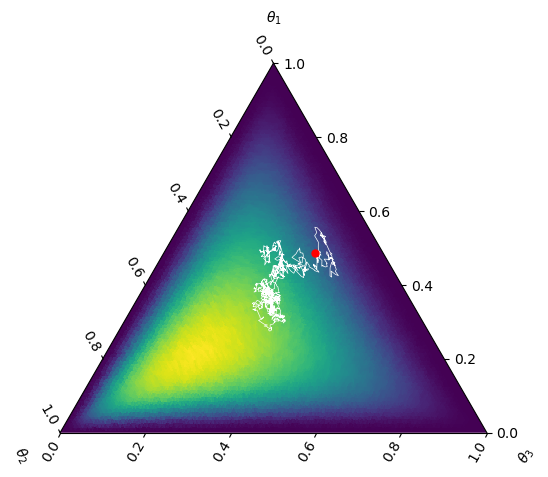

In [216]:
ax = plt.subplot(projection="ternary")
t, l, r, v = make_ternary_vals(h, edges)

ax.tripcolor(l, t, r, jnp.log(v + 1), shading="flat", edgecolors="none", vmin=0)
ax.set_facecolor(plt.cm.viridis(0))

fraction = int(theta_timeline.shape[0] * T)
t_theta, l_theta, r_theta = theta_timeline[:fraction, 0, 0], theta_timeline[:fraction, 1, 0], theta_timeline[:fraction, 2, 0]
ax.plot(t_theta, l_theta, r_theta, color="w", linewidth=0.5)

# plot point at the end
ax.plot(t_theta[-1], l_theta[-1], r_theta[-1], color="r", marker="o", markersize=5)

_ = ax.set_tlabel(r"$\theta_1$")
_ = ax.set_llabel(r"$\theta_2$")
_ = ax.set_rlabel(r"$\theta_3$")